In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.nn.utils import parameters_to_vector
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from typing import List
from typing import Dict

# get things running on server

In [2]:
def compute_hvp(network: nn.Module, loss_fn: nn.Module, loader: DataLoader, vector: torch.Tensor):
    
    device = vector.device
    
    p = len(parameters_to_vector(network.parameters()))
    hvp = torch.zeros(p, device = device)
    
    for data, target in loader:

        data, target = data.to(device), target.to(device)
        preds = network(data)

        if isinstance(loss_fn, nn.MSELoss):
            target_tensor = F.one_hot(target, num_classes=preds.size(1)).float().to(device)
        else:
            target_tensor = target

        loss = loss_fn(preds, target_tensor) / len(loader.dataset)
        grads = torch.autograd.grad(loss, network.parameters(), create_graph = True)
        dot = parameters_to_vector(grads).mul(vector).sum()
        grads2 = torch.autograd.grad(dot, network.parameters(), retain_graph = True)
        hvp += parameters_to_vector(grads2)
        
    return hvp

In [3]:
def lanczos(matrix_vector, dim: int, neigs: int, device: torch.device):
    
    def mv(x):
        v = torch.tensor(x, dtype = torch.float, device = device)
        hv = matrix_vector(v)
        return hv.to('cpu').numpy()
    
    op = LinearOperator((dim, dim), matvec = mv)
    evals, _ = eigsh(op, k = neigs)
    sorted_evals = np.sort(evals)[::-1].copy()
    return torch.from_numpy(sorted_evals).float()

In [4]:
class FCNN(nn.Module):

    def __init__(self, activation: str, hidden_sizes: List[int]):

        super().__init__()
        act = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}[activation]
        layers = [nn.Flatten()]
        in_size = 28 * 28
        
        for hs in hidden_sizes:
            layers.append(nn.Linear(in_size, hs))
            layers.append(act)
            in_size = hs
            
        layers.append(nn.Linear(in_size, 10))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
def generate_visuals(
    iterations: int,
    losses: List[float],
    accs: List[float],
    traj_lengths: List[float],
    eigs: List[List[float]],
    cumulative_changes: Dict[str, float],
    learning_rate: float,
    hessian_k: int
):
    iters = list(range(1, iterations + 1))
    
    min_loss, max_loss = min(losses), max(losses)
    padding = 0.1 * (max_loss - min_loss)
    plt.figure()
    plt.plot(iters, losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(min_loss - padding, max_loss + padding)
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(iters, accs)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.show()

    cum_dist = np.cumsum(traj_lengths) 
    plt.figure()
    plt.plot(iters, cum_dist)
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Distance')
    plt.title('Cumulative Optimization Trajectory Length')
    plt.grid(True)
    plt.show()

    plt.figure()
    for i in range(hessian_k):
        xs, ys = [], []
        for epoch, row in enumerate(eigs, start=1):
            val = row[i]
            if val is not None:
                xs.append(epoch)
                ys.append(val)
        plt.plot(xs, ys, label=f'λ_{i+1}')
    plt.axhline(2/learning_rate, linestyle=':', label='2/η')
    plt.xlabel('Iteration')
    plt.ylabel('Eigenvalue')
    plt.title('Top Hessian Eigenvalues')
    plt.legend()
    plt.grid(True)
    plt.show()

    top = sorted(cumulative_changes.items(), key=lambda x: x[1], reverse=True)[:5]
    names, vals = zip(*top)
    plt.figure()
    plt.barh(names, vals)
    plt.xlabel('Cumulative Parameter Change Norm')
    plt.title('Top 5 Principal Parameters')
    plt.grid(True)
    plt.show()
    print('Top 5 parameters by cumulative change:', names)

In [ ]:
def run_experiment(
    subset_size: int,
    seed_data: int,
    seed_params: int,
    hidden_sizes: List[int],
    activation: str,
    loss_fn: str,
    learning_rate: float,
    iterations: int,
    hessian_freq: int,
    hessian_k: int
):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    print(f"Using device: {device}")

    initial_state = torch.get_rng_state()

    torch.manual_seed(seed_data)
    full_train = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
    subset = Subset(full_train, torch.randperm(len(full_train))[:subset_size].tolist())
    loader = DataLoader(subset, batch_size = len(subset), shuffle = False)

    torch.set_rng_state(initial_state)
    torch.manual_seed(seed_params)

    model = FCNN(activation, hidden_sizes).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    criterion = {'cross_entropy': nn.CrossEntropyLoss(), 'mse': nn.MSELoss()}[loss_fn]
    criterion_sum = {'cross_entropy': nn.CrossEntropyLoss(reduction = 'sum'), 'mse': nn.MSELoss(reduction = 'sum')}[loss_fn]

    prev_params = parameters_to_vector(model.parameters()).detach().clone().to(device)
    prev_param_dict = {name: param.clone().detach() for name, param in model.named_parameters()}
    cumulative_changes = {name: 0.0 for name, _ in model.named_parameters()}

    losses, accs, eigs, traj_lengths = [], [], [], []

    for epoch in range(1, iterations + 1):

        for data, target in loader:

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            if loss_fn == 'mse':
                target_tensor = F.one_hot(target, num_classes=output.size(1)).float().to(device)
            else:
                target_tensor = target

            loss = criterion(output, target_tensor)
            loss.backward()
            optimizer.step()

        pred = output.argmax(dim = 1)
        acc = pred.eq(target).sum().item() / len(target)
        losses.append(loss.item())
        accs.append(acc)
        current_params = parameters_to_vector(model.parameters()).detach().clone().to(device)
        step = current_params - prev_params
        traj_lengths.append(step.norm().item())
        prev_params = current_params


        for name, param in model.named_parameters():
            delta = param.detach() - prev_param_dict[name]
            cumulative_changes[name] += delta.abs().norm().item()
            prev_param_dict[name] = param.detach().clone()

        if epoch % hessian_freq == 0:
            hv_loader = DataLoader(subset, batch_size = len(subset), shuffle = False)
            evals = lanczos(
                lambda v: compute_hvp(model, criterion_sum, hv_loader, v),
                dim = len(current_params),
                neigs = hessian_k,
                device = device
            )
            eigs.append(evals.cpu().tolist())
        else:
            eigs.append([None] * hessian_k)

        print(f"Iter {epoch}/{iterations} Loss: {loss.item():.4f} Acc: {acc:.4f} Eigs: {eigs[-1]}")

    generate_visuals(iterations, losses, accs, traj_lengths, eigs, cumulative_changes, learning_rate, hessian_k)

Using device: mps
Iter 1/2000 Loss: 0.1082 Acc: 0.1084 Eigs: [None, None, None]
Iter 2/2000 Loss: 0.1080 Acc: 0.1086 Eigs: [None, None, None]
Iter 3/2000 Loss: 0.1078 Acc: 0.1090 Eigs: [None, None, None]
Iter 4/2000 Loss: 0.1076 Acc: 0.1098 Eigs: [None, None, None]
Iter 5/2000 Loss: 0.1074 Acc: 0.1098 Eigs: [None, None, None]
Iter 6/2000 Loss: 0.1072 Acc: 0.1100 Eigs: [None, None, None]
Iter 7/2000 Loss: 0.1070 Acc: 0.1098 Eigs: [None, None, None]
Iter 8/2000 Loss: 0.1068 Acc: 0.1102 Eigs: [None, None, None]
Iter 9/2000 Loss: 0.1066 Acc: 0.1102 Eigs: [None, None, None]
Iter 10/2000 Loss: 0.1064 Acc: 0.1108 Eigs: [None, None, None]
Iter 11/2000 Loss: 0.1062 Acc: 0.1118 Eigs: [None, None, None]
Iter 12/2000 Loss: 0.1060 Acc: 0.1118 Eigs: [None, None, None]
Iter 13/2000 Loss: 0.1058 Acc: 0.1120 Eigs: [None, None, None]
Iter 14/2000 Loss: 0.1057 Acc: 0.1120 Eigs: [None, None, None]
Iter 15/2000 Loss: 0.1055 Acc: 0.1124 Eigs: [None, None, None]
Iter 16/2000 Loss: 0.1053 Acc: 0.1126 Eigs: [N

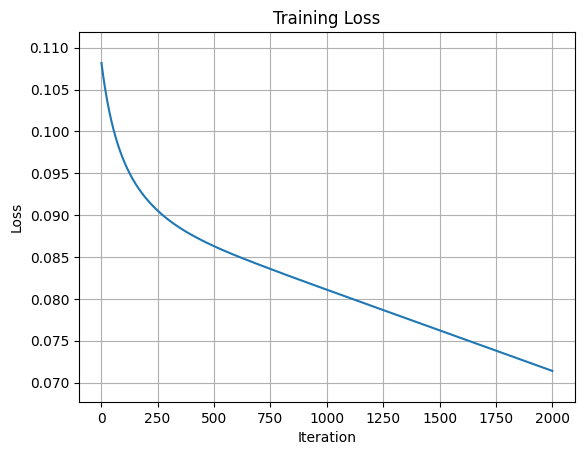

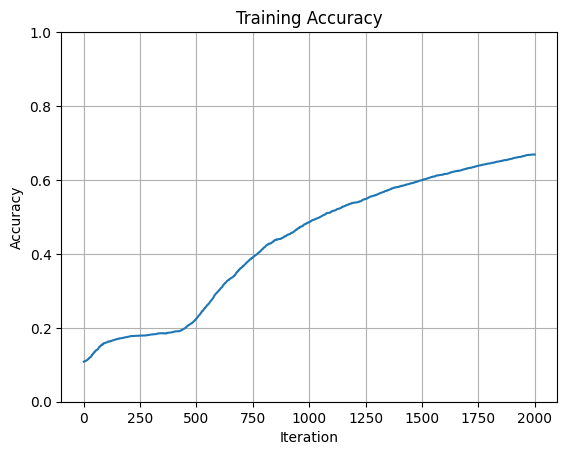

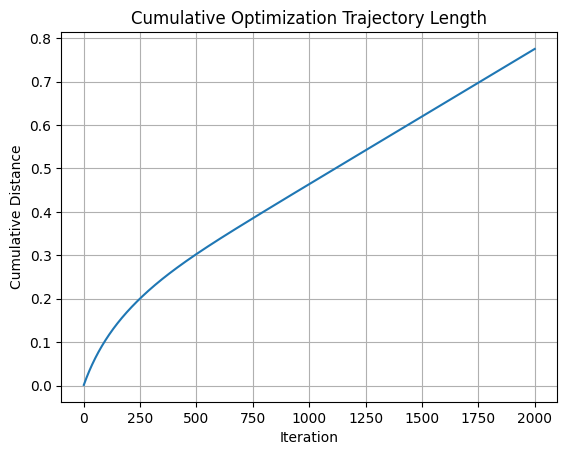

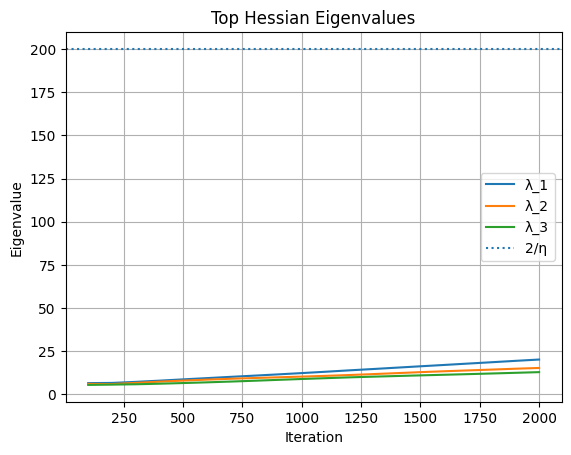

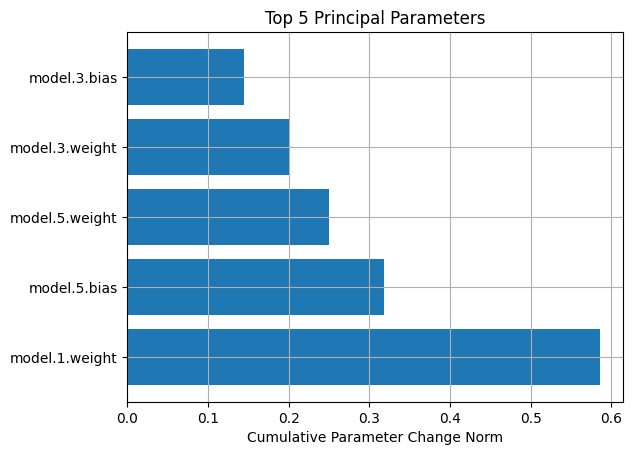

Top 5 parameters by cumulative change: ('model.1.weight', 'model.5.bias', 'model.5.weight', 'model.3.weight', 'model.3.bias')


In [8]:
run_experiment(
    subset_size = 5000,
    seed_data = 1,
    seed_params = 1,
    hidden_sizes = [32, 32],
    activation = 'relu',
    loss_fn = 'mse',
    learning_rate = 0.01,
    iterations = 2000,
    hessian_freq = 100,
    hessian_k = 3
)

Using device: mps
Iter 1/2000 Loss: 0.1068 Acc: 0.1054 Eigs: [None, None, None]
Iter 2/2000 Loss: 0.1067 Acc: 0.1054 Eigs: [None, None, None]
Iter 3/2000 Loss: 0.1066 Acc: 0.1054 Eigs: [None, None, None]
Iter 4/2000 Loss: 0.1065 Acc: 0.1054 Eigs: [None, None, None]
Iter 5/2000 Loss: 0.1064 Acc: 0.1054 Eigs: [None, None, None]
Iter 6/2000 Loss: 0.1063 Acc: 0.1054 Eigs: [None, None, None]
Iter 7/2000 Loss: 0.1062 Acc: 0.1056 Eigs: [None, None, None]
Iter 8/2000 Loss: 0.1061 Acc: 0.1056 Eigs: [None, None, None]
Iter 9/2000 Loss: 0.1060 Acc: 0.1056 Eigs: [None, None, None]
Iter 10/2000 Loss: 0.1059 Acc: 0.1056 Eigs: [None, None, None]
Iter 11/2000 Loss: 0.1058 Acc: 0.1056 Eigs: [None, None, None]
Iter 12/2000 Loss: 0.1057 Acc: 0.1056 Eigs: [None, None, None]
Iter 13/2000 Loss: 0.1056 Acc: 0.1056 Eigs: [None, None, None]
Iter 14/2000 Loss: 0.1055 Acc: 0.1056 Eigs: [None, None, None]
Iter 15/2000 Loss: 0.1054 Acc: 0.1060 Eigs: [None, None, None]
Iter 16/2000 Loss: 0.1053 Acc: 0.1060 Eigs: [N

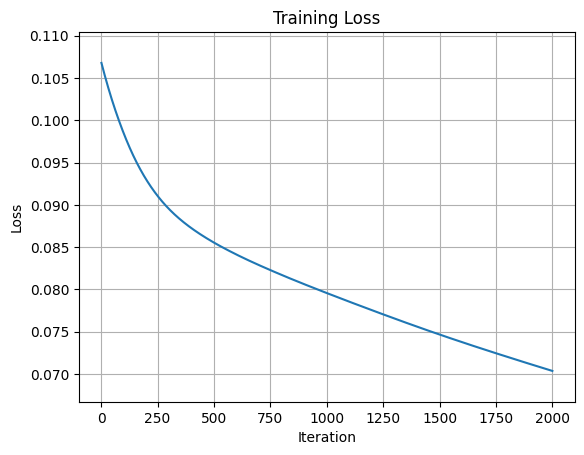

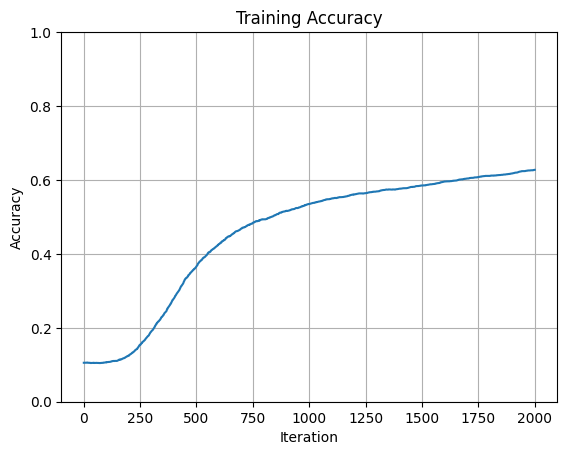

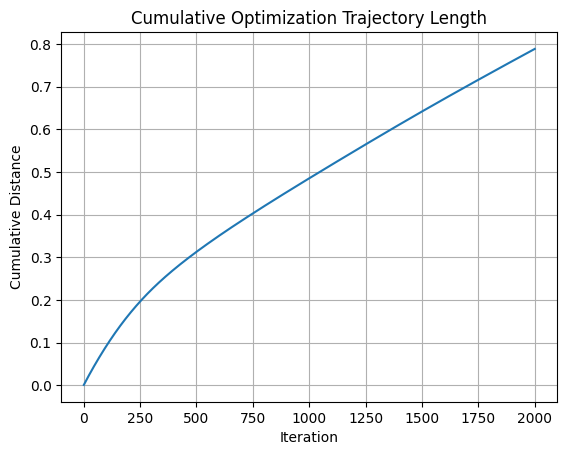

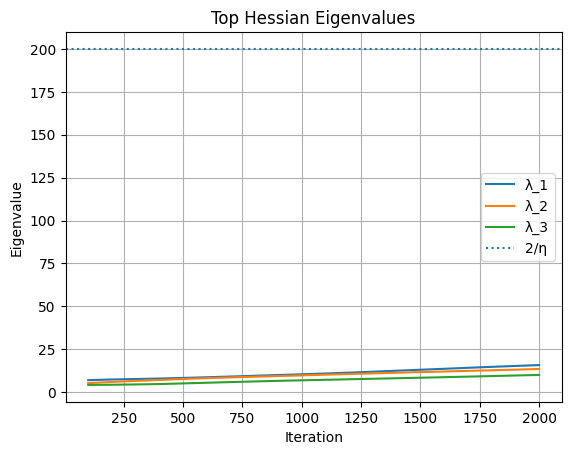

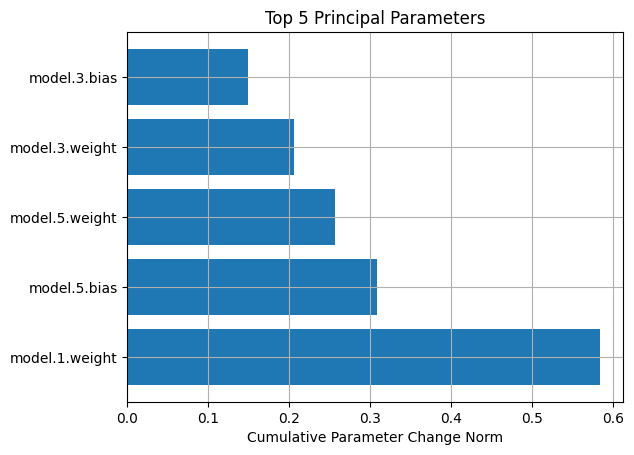

Top 5 parameters by cumulative change: ('model.1.weight', 'model.5.bias', 'model.5.weight', 'model.3.weight', 'model.3.bias')


In [9]:
run_experiment(
    subset_size = 5000,
    seed_data = 1,
    seed_params = 2,
    hidden_sizes = [32, 32],
    activation = 'relu',
    loss_fn = 'mse',
    learning_rate = 0.01,
    iterations = 2000,
    hessian_freq = 100,
    hessian_k = 3
)